# Brain Tumor Detection using ResNet Architecture. (Experimental Phase)

#### The experimentation phase of the project consists of evaluating various hyper-parameters to find the optimal performance for the ResNet Architecture.


When running any code it’s beneficial to change the “RunTime” type to T4-GPU

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.python.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras.optimizers import Adam, RMSprop
import numpy as np
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline


In [ ]:
# mount the drive using the following commands:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navigating my Drive directory to find dataset (For Examiner: Only run if you have transfered the folder to your drive. Detials Explained in the report [Appendix])

%cd /content/drive/My Drive/Final Project/BrainTumor Project/Brain_MRI

/content/drive/My Drive/Colab Notebooks/Healthcare AI Datasets/Brain_MRI


In [ ]:
# data containing path to Brain MRI and their corresponding mask

brain_df = pd.read_csv('data_mask.csv')

In [ ]:
# Display information about the Dataset

brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


#A: TRAIN A CLASSIFIER MODEL TO DETECT IF TUMOR EXISTS OR NOT (ResNet)

In [ ]:
# Drop the patient id column

brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# split the data into train and test data

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
# create a image generator

from keras.preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split of 0.15

datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)

In [ ]:
# Create a data generator for train images

train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=32,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=32,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [ ]:
# Create a data generator for test images

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=32,
shuffle=False,
class_mode='binary',
target_size=(256,256))

Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Get the ResNet50 base model

basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
# freeze the model weights

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Add classification head to the base model

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)#
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust the learning rate
    loss='categorical_crossentropy',  # Use categorical cross-entropy for binary classification
    metrics=['accuracy']
)

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights-exp.hdf5", verbose=1, save_best_only=True)

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("classifier-resnet-model-exp.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
# Training the model

history = model.fit(train_generator, steps_per_epoch= train_generator.n // 32, epochs = 30, validation_data= valid_generator, validation_steps= valid_generator.n // 32, callbacks=[checkpointer, earlystopping])

Epoch 1/30
88/88 [==============================] - ETA: 0s - loss: 0.4414 - accuracy: 0.7845
Epoch 1: val_loss improved from inf to 0.67626, saving model to classifier-resnet-weights-exp.hdf5
88/88 [==============================] - 77s 539ms/step - loss: 0.4414 - accuracy: 0.7845 - val_loss: 0.6763 - val_accuracy: 0.6646
Epoch 2/30
88/88 [==============================] - ETA: 0s - loss: 0.3265 - accuracy: 0.8497
Epoch 2: val_loss improved from 0.67626 to 0.67610, saving model to classifier-resnet-weights-exp.hdf5
88/88 [==============================] - 46s 522ms/step - loss: 0.3265 - accuracy: 0.8497 - val_loss: 0.6761 - val_accuracy: 0.6625
Epoch 3/30
88/88 [==============================] - ETA: 0s - loss: 0.2552 - accuracy: 0.8935
Epoch 3: val_loss did not improve from 0.67610
88/88 [==============================] - 40s 449ms/step - loss: 0.2552 - accuracy: 0.8935 - val_loss: 0.6812 - val_accuracy: 0.6667
Epoch 4/30
88/88 [==============================] - ETA: 0s - loss: 0.186

In [ ]:
# Interactive graph of the Training and Validation Loss

import plotly.graph_objects as go

# Access training loss and validation loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs (e.g., [1, 2, 3, ...])
epochs = list(range(1, len(train_loss) + 1))  # Convert range to a list

# Create a Plotly figure
fig = go.Figure()

# Add training loss trace
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss'))

# Add validation loss trace
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss'))

# Set layout options and adjust figure size
fig.update_layout(
    title='Training and Validation Loss',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    hovermode='closest',  # Enables interactive hovering
    width=800,  # Adjust the width in pixels
    height=400  # Adjust the height in pixels
)

# Show the interactive plot
fig.show()

In [ ]:
# Interactive graph of the Training and Validation Accuracy

# Access training accuracy and validation accuracy from the history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs (e.g., [1, 2, 3, ...])
epochs = list(range(1, len(train_accuracy) + 1))  # Convert range to a list

# Create a Plotly figure
fig = go.Figure()

# Add training accuracy trace
fig.add_trace(go.Scatter(x=epochs, y=train_accuracy, mode='lines+markers', name='Training Accuracy'))

# Add validation accuracy trace
fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, mode='lines+markers', name='Validation Accuracy'))

# Set layout options and adjust figure size
fig.update_layout(
    title='Training and Validation Accuracy',
    xaxis_title='Epochs',
    yaxis_title='Accuracy',
    hovermode='closest',  # Enables interactive hovering
    width=800,  # Adjust the width in pixels
    height=400  # Adjust the height in pixels
)

# Show the interactive plot
fig.show()

#B: ASSESS TRAINED MODEL PERFORMANCE (ResNet)

In [ ]:
# Load pretrained model (instead of training the model for 1+ hours)

with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# make prediction

test_predict = model.predict(test_generator, steps = test_generator.n // 32, verbose =1)

18/18 [==============================] - 5s 295ms/step


In [ ]:
test_predict.shape

(576, 2)

In [ ]:
# Obtain the predicted class from the model prediction

predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

array(['0', '1', '0', '1', '1', '0', '0', '1', '1', '1', '0', '1', '0',
       '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '1', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '1', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0', '0',
       '0', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '1', '1',
       '1', '0', '1', '0', '0', '0', '1', '0', '0', '1', '0', '1', '0',
       '1', '0', '0', '0', '0', '1', '1', '0', '0', '0', '1', '0', '1',
       '1', '0', '0', '0', '0', '1', '1', '1', '0', '1', '0', '0', '1',
       '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '1', '1',
       '1', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '1', '1',
       '0', '0', '0', '1', '1', '0', '0', '1', '1', '1', '1', '0', '0',
       '0', '0', '0', '0', '0', '1', '1', '0', '0', '0', '0', '1', '1',
       '0', '0', '1', '0', '0', '0', '0', '0', '1', '1', '0', '1

In [ ]:
# since we have used test generator, it limited the images to len(predict), due to batch size

original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [ ]:
# Obtain the accuracy of the model

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)

print("Model Accuracy: ", accuracy)

Model Accuracy:  0.9878472222222222


In [ ]:
# Classification Report

from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       361
           1       0.99      0.98      0.98       215

   micro avg       0.99      0.99      0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/usr/local/lib/python3.10/dist-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison



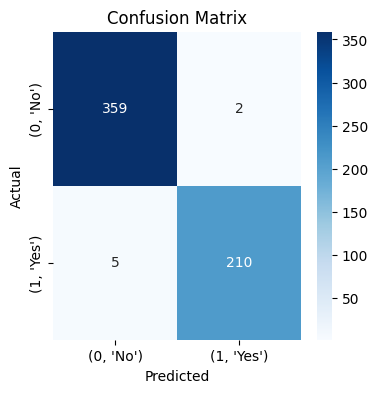

In [ ]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(original, predict)

# Define class labels
class_labels = ["(0, 'No')", "(1, 'Yes')"]

# Create a figure and axis for the confusion matrix
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()